# Introduction
Welcome to Practical 3 for Graph Representation Learning.  In this practical, you are expected to first implement two functions from scratch: **Graph Mini-Batching** and **Global Pooling**. Then, you need to incorporate these two functions into a graph neural network model to solve a **Graph Classification** task.

- **Graph Mini-Batching** A mini-batch groups a set of graphs into a unified representation where it can efficiently be processed in parallel.
- **Global Pooling** Obtain the graph feature based on all node features in the graph, in which you can use different operations such as summation, mean and max.

We will be using [PyTorch](https://pytorch.org/docs/stable/index.html) and [PyG](https://pytorch-geometric.readthedocs.io/en/latest/) for experiments.

The notebook is divided into sections, each of which comes with complete or partially completed code. Before each snippet of code there will be a description of what we are about to implement. The sections of code you need to complete are marked as **Tasks**.

Please ensure that you operate within the framework given in the notebook and bring any questions you may have to the practical demonstrators. We suggest that you **DO NOT** edit code that is a part of the framework, since this will make it more difficult for demonstrators to assist if your code is broken.

Since we are working in a Jupyter Notebook, the code is very interactive. When you're stuck on something, try adding a new block of code below what you're working on and using it to debug your code.

## Installing dependencies
First of all, we advise you to enable GPU acceleration for your notebook. This can be done by navigating to `Runtime > Change runtime type > Hardware accelerator (GPU) > Save`. You may getting an error explaining that no GPUs are currently available. This is fine, you don't really need them for this practical, however they'll make your computations significantly faster.

Some other tips & tricks:
- press `Shift + Enter` to run a cell and move to the next one (`Ctrl + Enter` to only run it)
- when you execute a cell, the variables you create are saved into a global namespace. As a consequence, changes in the code will not take effect until you re-run that specific cell.
- remember to save your notebook every once in a while!

In [ ]:
# Download the corresponding PyTorch Geometric module
%%capture
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

# Imports

Run the following blocks of code to install and import and the necessary python packages.

In [2]:
# Let's first import all the things we are gonna need for this task
import torch
import time
import torch.nn as nn
import numpy as np
import random
import torch.nn.functional as F
from torch_geometric.utils import scatter
from torch_geometric.nn import MessagePassing
import torch_geometric.utils as U
# torch_geometric only used to load the Cora dataset
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import DataLoader
from torch_geometric.data.data import Data
import torch_geometric.utils as U
import torch
from sklearn.metrics import roc_auc_score
from torch_geometric.datasets import TUDataset


# Dataset

## Loading MUTAG from TUDataset
We will use TUDataset to load the MUTAG dataset, which contains molecular graphs of 188 chemical compounds divided into two classes according to their mutagenic effect on a bacterium.

We construct three lists: A, X, Y, which correspond to a list of adj_matrix, a list of node features and a list of graph labels, respectively.

Please **DO NOT** modify any part of the following block.

In [63]:
# please **DO NOT** modify  any part of the following code  in this cell
raw_dataset = TUDataset(root='data/TUDataset', name='MUTAG')
batch_size = 32
A = []
X = []
Y = []
for graph in raw_dataset:
    adj_matrix = U.to_dense_adj(graph.edge_index).squeeze(0)
    A.append(adj_matrix)
    X.append(graph.x)
    Y.append(graph.y)

print(len(A))

188


We can then run the following cell to output the first one element in the three constructed lists.

In [64]:
print(A[0].shape)
print(X[0].shape)
print(Y[0].shape)

torch.Size([17, 17])
torch.Size([17, 7])
torch.Size([1])


## Task 1
Define an iterator `graph_mini_batch` that takes in a list of adj_matrix (A), a list of node features (X), a list of graph labels (Y) and a batch_size B=64, and outputs four items $A_B$, $X_B$, $Y_B$ and $\textsf{Batch}$ each time, such that the batched Adjacency matrices  $A_B$ are stacked in a diagonal fashion (creating a giant graph that holds multiple isolated subgraphs), and the batched node features list $X_B$ and the batched graph label list $Y_B$ are simply concatenated in the node dimension, i.e.,

\begin{split}\mathbf{A_B} = \begin{bmatrix} \mathbf{A}_1 & & \\ & \ddots & \\ & & \mathbf{A}_n \end{bmatrix}, \qquad \mathbf{X_B} = \begin{bmatrix} \mathbf{X}_1 \\ \vdots \\ \mathbf{X}_n \end{bmatrix}, \qquad \mathbf{Y_B} = \begin{bmatrix} \mathbf{Y}_1 \\ \vdots \\ \mathbf{Y}_n \end{bmatrix}.\end{split}

Furthermore, you are expected to output a  **`Batch` vector**, which maps each node to its respective graph in the batch:

$$
\textrm{Batch} = [ 0, \ldots, 0, 1, \ldots, 1, 2, \ldots, n, \ldots, n]
$$

**Hints:**
1. use the keyword **yield** to make your function be an iterator.
2. note that the last batch might not have the enough items satisfying the specified batch size, so your function should be able to deal with such a case and have a correct output.

In [74]:
def graph_mini_batch(adj_matrix_list, x_list, y_list, batch_size=64):

    num_graphs = len(adj_matrix_list)
    # print(num_graphs)

    num_batches = int(num_graphs/batch_size)
    # print(num_batches)

    for i in range(num_batches):
        adj_batch_list = adj_matrix_list[i:i+batch_size]
        x_batch_list = x_list[i:i+batch_size]
        y_batch_list = y_list[i:i+batch_size]

        # create A_B
        total_rows = sum(mat.shape[0] for mat in adj_batch_list)
        total_cols = sum(mat.shape[1] for mat in adj_batch_list)

        node_counts = [A.shape[0] for A in adj_batch_list]
        
        A_B = np.zeros((total_rows, total_cols)) # Initialize a large zero matrix
        # Fill in each block along the diagonal
        row_start, col_start = 0, 0
        for mat in adj_batch_list:
            rows, cols = mat.shape
            A_B[row_start:row_start+rows, col_start:col_start+cols] = mat
            row_start += rows
            col_start += cols

        # create X_B, Y_B
        X_B = np.concatenate(x_batch_list)
        Y_B = np.concatenate(y_batch_list)

        Batch = np.concatenate([[j] * node_counts[j] for j in range(len(adj_batch_list))])
        A_B = torch.tensor(A_B)
        X_B = torch.tensor(X_B)
        Y_B = torch.tensor(Y_B)
        Batch = torch.tensor(Batch)

        yield A_B, X_B, Y_B, Batch

    if (batch_size*num_batches < num_graphs):
        n = batch_size*num_batches

        adj_batch_list = adj_matrix_list[n:num_graphs]
        x_batch_list = x_list[n:num_graphs]
        y_batch_list = y_list[n:num_graphs]
        
        node_counts = [A.shape[0] for A in adj_batch_list]
        total_rows = sum(mat.shape[0] for mat in adj_batch_list)
        total_cols = sum(mat.shape[1] for mat in adj_batch_list)

        A_B = np.zeros((total_rows, total_cols)) 
        row_start, col_start = 0, 0
        for mat in adj_batch_list:
            rows, cols = mat.shape
            A_B[row_start:row_start+rows, col_start:col_start+cols] = mat
            row_start += rows
            col_start += cols

        X_B = np.concatenate(x_batch_list)
        Y_B = np.concatenate(y_batch_list)
        Batch = np.concatenate([[j] * node_counts[j] for j in range(len(adj_batch_list))])

        A_B = torch.tensor(A_B)
        X_B = torch.tensor(X_B)
        Y_B = torch.tensor(Y_B)
        Batch = torch.tensor(Batch)


        yield A_B, X_B, Y_B, Batch


In [60]:
# import numpy as np
# import scipy.sparse as sp

# def graph_mini_batch(adj_matrix_list, x_list, y_list, batch_size=64):
#     num_graphs = len(adj_matrix_list)
    
#     for i in range(0, num_graphs, batch_size):
#         batch_adj = adj_matrix_list[i:i + batch_size]
#         batch_features = x_list[i:i + batch_size]
#         batch_labels = y_list[i:i + batch_size]
        
#         batch_adj = [sp.csr_matrix(A) if not sp.issparse(A) else A for A in batch_adj]
#         node_counts = [A.shape[0] for A in batch_adj]
        
#         A_B = sp.block_diag(batch_adj, format='csr')
#         X_B = np.vstack(batch_features)
#         Y_B = np.concatenate(batch_labels)
        
#         Batch = np.concatenate([[j] * node_counts[j] for j in range(len(batch_adj))])
        
#         yield A_B, X_B, Y_B, Batch


In [75]:
# Test your batch function here
for adj_matrix, x, y, batch in graph_mini_batch(A, X, Y, batch_size):
     print(f"adj_matrix_size {adj_matrix.size()}") 
     print(f"x_size {x.size()}")         
     print(f"y.size {y.size()}")
     print(f"batch.size {batch.size()}")

adj_matrix_size torch.Size([585, 585])
x_size torch.Size([585, 7])
y.size torch.Size([32])
batch.size torch.Size([585])
adj_matrix_size torch.Size([591, 591])
x_size torch.Size([591, 7])
y.size torch.Size([32])
batch.size torch.Size([591])
adj_matrix_size torch.Size([591, 591])
x_size torch.Size([591, 7])
y.size torch.Size([32])
batch.size torch.Size([591])
adj_matrix_size torch.Size([595, 595])
x_size torch.Size([595, 7])
y.size torch.Size([32])
batch.size torch.Size([595])
adj_matrix_size torch.Size([590, 590])
x_size torch.Size([590, 7])
y.size torch.Size([32])
batch.size torch.Size([590])
adj_matrix_size torch.Size([526, 526])
x_size torch.Size([526, 7])
y.size torch.Size([28])
batch.size torch.Size([526])


## Task 2
Define a function `global_sum_pool` which takes a batch of node features and a Batch vector mapping each node to its respective graph in the batch, and outputs a batch of graph representation vectors by summing all node features in a graph.

**Hints:** You are allowed to use the function scatter from torch_scatter library. See [here](https://pytorch-scatter.readthedocs.io/en/latest/functions/scatter.html#torch_scatter.scatter) for a detailed introduction about the usage.

In [76]:
#scaler? sparse matrix? efficency? in practice?
def global_sum_pool(x, batch):
    
    num_graphs = batch.max().item() + 1  # Calculate the number of graphs

    graph_representations = scatter(x, batch, dim=0, reduce='sum', dim_size=num_graphs)

    return graph_representations


In [77]:
# Test your pooling function, assuming you are given a mini-batch of node features and a batch vector
for _, x, _ , batch in graph_mini_batch(A, X, Y, batch_size):
      sum_graph_rep =  global_sum_pool(x, batch)
      print(sum_graph_rep.size())

torch.Size([32, 7])
torch.Size([32, 7])
torch.Size([32, 7])
torch.Size([32, 7])
torch.Size([32, 7])
torch.Size([28, 7])


# Model
We now implement a GNN model, `GIN`, which is used to do the graph classification. **DO NOT** change the following block.

In [78]:
class GINConv(MessagePassing):
    def __init__(self, emb_dim):
        '''
            emb_dim (int): node embedding dimensionality
        '''
        super(GINConv, self).__init__(aggr = "add")

        self.mlp = torch.nn.Sequential(torch.nn.Linear(emb_dim, 2*emb_dim), torch.nn.BatchNorm1d(2*emb_dim), torch.nn.ReLU(), torch.nn.Linear(2*emb_dim, emb_dim))
        self.eps = torch.nn.Parameter(torch.Tensor([0]))

    def forward(self, x, edge_index):
        out = self.mlp((1 + self.eps) *x + self.propagate(edge_index, x=x))
        return out

    def message(self, x_j):
        return F.relu(x_j)

    def update(self, aggr_out):
        return aggr_out


### GNN to generate node embedding
class GIN(torch.nn.Module):
    """
    Output:
        node representations
    """
    def __init__(self, num_layer, emb_dim, hidden_dim, drop_ratio = 0, JK = "last", residual = False):
        '''
            emb_dim (int): node embedding dimensionality
            num_layer (int): number of GNN message passing layers
        '''
        super(GIN, self).__init__()
        self.num_layer = num_layer
        self.drop_ratio = drop_ratio
        self.JK = JK
        ### add residual connection or not
        self.residual = residual
        if self.num_layer < 2:
            raise ValueError("Number of GNN layers must be greater than 1.")

        self.embed = torch.nn.Linear(emb_dim, hidden_dim)
        self.convs = torch.nn.ModuleList()
        self.batch_norms = torch.nn.ModuleList()
        for layer in range(num_layer):
            self.convs.append(GINConv(hidden_dim))
            self.batch_norms.append(torch.nn.BatchNorm1d(hidden_dim))

    def forward(self, x, edge_index):
        h_list = [self.embed(x)]
        for layer in range(self.num_layer):
            h = self.convs[layer](h_list[layer], edge_index)
            h = self.batch_norms[layer](h)
            if layer == self.num_layer - 1:
                #remove relu for the last layer
                h = F.dropout(h, self.drop_ratio, training = self.training)
            else:
                h = F.dropout(F.relu(h), self.drop_ratio, training = self.training)

            if self.residual:
                h += h_list[layer]

            h_list.append(h)
        ### Different implementations of Jk-concat
        if self.JK == "last":
            node_representation = h_list[-1]
        elif self.JK == "sum":
            node_representation = 0
            for layer in range(self.num_layer + 1):
                node_representation += h_list[layer]

        return node_representation

### Define the hyperparameters we are going to use

In [105]:
params = {
    "input_features": 7,
    "hidden_features": 50,
    "num_layers": 3,
    "learning_rate": 1e-4,
    "weight_decay": 0,
    "num_epochs": 100,
    "num_classes": 2,
    "batch_size": 62
}


Now, we come to the most exciting part, that is, training and evaluating the model based on the graph mini-batch and the graph pooling functions you implemented above.

By checking the training time,  you can see the power of the graph batching by changing the batch_size, i.e., from 1 to 64.

In [106]:
begin_time = time.time()

model = GIN(params["num_layers"], params["input_features"], params["hidden_features"])
pooling = global_sum_pool
graph_pred_linear = torch.nn.Linear(params["hidden_features"], params["num_classes"])
loss_fn = nn.CrossEntropyLoss()
model_param_group = [{"params": model.parameters(), "lr": params["learning_rate"]}]
if graph_pred_linear is not None:
        model_param_group.append(
            {"params": graph_pred_linear.parameters(), "lr": params["learning_rate"]}
        )

optimizer = torch.optim.AdamW(model_param_group,
                                lr=params["learning_rate"],
                                weight_decay=params["weight_decay"])
for epoch in range(params["num_epochs"]):
  model.train()
  for adj_matrix, x, y, batch in graph_mini_batch(A, X, Y, params["batch_size"]):
      optimizer.zero_grad()
      edge_index = U.dense_to_sparse(adj_matrix)[0]
      nodes = model(x, edge_index)
      graph_reps = pooling(nodes, batch)
      pred = graph_pred_linear(graph_reps)
      loss = loss_fn(pred, y)
      loss.backward()
      optimizer.step()
  if epoch % 10 == 0:
      model.eval()
      correct = 0
      total_num = 0
      for adj_matrix, x, y, batch in graph_mini_batch(A, X, Y, params["batch_size"]):
        optimizer.zero_grad()
        edge_index = U.dense_to_sparse(adj_matrix)[0]
        nodes = model(x, edge_index)
        graph_reps = pooling(nodes, batch)
        pred = graph_pred_linear(graph_reps)
        correct += (pred.argmax(dim=-1) == y).sum()
        total_num += len(y)
      print("epoch={}, loss={}, accuracy={}".format(epoch, loss.item(), correct/total_num))
print("time={}".format(time.time()-begin_time))

epoch=0, loss=1.020653486251831, accuracy=0.25531914830207825
epoch=10, loss=8.111856004688889e-05, accuracy=0.271276593208313
epoch=20, loss=2.1278618078213185e-05, accuracy=0.9095744490623474
epoch=30, loss=1.1265208740951493e-05, accuracy=0.9521276354789734
epoch=40, loss=7.808174814272206e-06, accuracy=0.9521276354789734
epoch=50, loss=5.424006303655915e-06, accuracy=0.9680851101875305
epoch=60, loss=4.351128154667094e-06, accuracy=0.9680851101875305
epoch=70, loss=3.635875600593863e-06, accuracy=0.9680851101875305
epoch=80, loss=2.980227009174996e-06, accuracy=0.9680851101875305
epoch=90, loss=2.3841823804104934e-06, accuracy=0.9680851101875305
time=3.9510109424591064


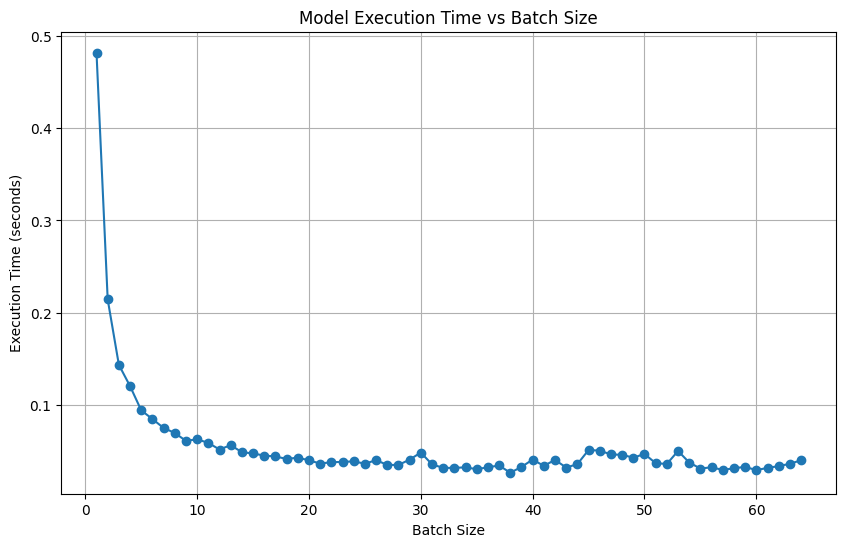

In [107]:
import matplotlib.pyplot as plt

batch_sizes = range(1, 65)  
execution_times = []

for batch_size in batch_sizes:
    # Update the batch size in the parameters dictionary
    params["batch_size"] = batch_size
    
    # Initialize model, pooling function, linear layer, loss, and optimizer
    model = GIN(params["num_layers"], params["input_features"], params["hidden_features"])
    pooling = global_sum_pool
    graph_pred_linear = torch.nn.Linear(params["hidden_features"], params["num_classes"])
    loss_fn = nn.CrossEntropyLoss()
    model_param_group = [{"params": model.parameters(), "lr": params["learning_rate"]}]
    if graph_pred_linear is not None:
        model_param_group.append(
            {"params": graph_pred_linear.parameters(), "lr": params["learning_rate"]}
        )
    optimizer = torch.optim.AdamW(model_param_group,
                                  lr=params["learning_rate"],
                                  weight_decay=params["weight_decay"])
    
    start_time = time.time()

    model.train()
    for adj_matrix, x, y, batch in graph_mini_batch(A, X, Y, params["batch_size"]):
        optimizer.zero_grad()
        edge_index = U.dense_to_sparse(adj_matrix)[0]
        nodes = model(x, edge_index)
        graph_reps = pooling(nodes, batch)
        pred = graph_pred_linear(graph_reps)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()

    execution_times.append(time.time() - start_time)

plt.figure(figsize=(10, 6))
plt.plot(batch_sizes, execution_times, marker='o')
plt.xlabel("Batch Size")
plt.ylabel("Execution Time (seconds)")
plt.title("Model Execution Time vs Batch Size")
plt.grid(True)
plt.show()


### Task 3 (Optional)
This is an optional task. You are expected to implement 10-Fold Cross-validation. The general procedure is as follows:

1. Shuffle the dataset randomly.
2. Split the dataset into $k$ groups.
For each unique group:
  - Take the group as a hold out or test data set
  - Take the remaining groups as a training data set
  - Fit a model on the training set and evaluate it on the test set.
  Retain the evaluation score and discard the model
  - Summarize the skill of the model using the sample of model evaluation scores

In [110]:
import numpy as np
import torch
from sklearn.model_selection import KFold
from torch import nn
import torch.optim as optim
import time

params = {
    "num_layers": 3,
    "input_features": X[0].shape[1],  
    "hidden_features": 64,
    "num_classes": len(torch.unique(torch.tensor(Y))), 
    "learning_rate": 0.001,
    "weight_decay": 0.0001,
    "batch_size": 32,
    "num_epochs": 10,
}

def train_and_evaluate(A_train, X_train, Y_train, A_test, X_test, Y_test, params):

    model = GIN(params["num_layers"], params["input_features"], params["hidden_features"])
    graph_pred_linear = torch.nn.Linear(params["hidden_features"], params["num_classes"])
    loss_fn = nn.CrossEntropyLoss()

    model_param_group = [{"params": model.parameters(), "lr": params["learning_rate"]}]
    model_param_group.append({"params": graph_pred_linear.parameters(), "lr": params["learning_rate"]})
    optimizer = optim.AdamW(model_param_group, lr=params["learning_rate"], weight_decay=params["weight_decay"])

    for epoch in range(params["num_epochs"]):
        model.train()
        for adj_matrix, x, y, batch in graph_mini_batch(A_train, X_train, Y_train, params["batch_size"]):
            optimizer.zero_grad()
            edge_index = U.dense_to_sparse(adj_matrix)[0]
            nodes = model(x, edge_index)
            graph_reps = global_sum_pool(nodes, batch)
            pred = graph_pred_linear(graph_reps)
            loss = loss_fn(pred, y)
            loss.backward()
            optimizer.step()

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for adj_matrix, x, y, batch in graph_mini_batch(A_test, X_test, Y_test, params["batch_size"]):
            edge_index = U.dense_to_sparse(adj_matrix)[0]
            nodes = model(x, edge_index)
            graph_reps = global_sum_pool(nodes, batch)
            pred = graph_pred_linear(graph_reps)
            correct += (pred.argmax(dim=-1) == y).sum().item()
            total += len(y)

    return correct / total

def cross_validate_model(A, X, Y, params, k=10):
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    scores = []
    
    for fold, (train_idx, test_idx) in enumerate(kfold.split(A)):
        print(f"Fold {fold + 1}/{k}")
        
        A_train = [A[i] for i in train_idx]
        X_train = [X[i] for i in train_idx]
        Y_train = [Y[i] for i in train_idx]
        A_test = [A[i] for i in test_idx]
        X_test = [X[i] for i in test_idx]
        Y_test = [Y[i] for i in test_idx]

        accuracy = train_and_evaluate(A_train, X_train, Y_train, A_test, X_test, Y_test, params)
        scores.append(accuracy)
        print(f"Fold {fold + 1} Accuracy: {accuracy:.4f}")
    
    mean_accuracy = np.mean(scores)
    std_accuracy = np.std(scores)
    print(f"Mean Accuracy: {mean_accuracy:.4f}, Standard Deviation: {std_accuracy:.4f}")
    return mean_accuracy, std_accuracy

begin_time = time.time()
mean_accuracy, std_accuracy = cross_validate_model(A, X, Y, params)
print("Total Time: {:.2f} seconds".format(time.time() - begin_time))


Fold 1/10
Fold 1 Accuracy: 0.9474
Fold 2/10
Fold 2 Accuracy: 0.7895
Fold 3/10
Fold 3 Accuracy: 0.8421
Fold 4/10
Fold 4 Accuracy: 0.7895
Fold 5/10
Fold 5 Accuracy: 0.6842
Fold 6/10
Fold 6 Accuracy: 0.6842
Fold 7/10
Fold 7 Accuracy: 0.6842
Fold 8/10
Fold 8 Accuracy: 0.6842
Fold 9/10
Fold 9 Accuracy: 0.8333
Fold 10/10
Fold 10 Accuracy: 0.8889
Mean Accuracy: 0.7827, Standard Deviation: 0.0913
Total Time: 4.09 seconds
